In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

import pickle

from matplotlib.patches import Circle

import warnings
warnings.filterwarnings('ignore')

#Visualiser le maximum possible d'information
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [2]:
import time

def elapsed_time(start, end, n_clusters):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Elapsed Time for {} clusters: {:0>2}:{:0>2}:{:05.2f}"
                .format(n_clusters, int(hours),int(minutes),seconds))

# Imports

In [3]:
data = pd.read_csv('df_rfm.csv',sep='\t',encoding='utf-8')

In [4]:
data_cui = data.set_index('customer_unique_id')
data_cui['first_order_date'] = data_cui['first_order_date'].astype('datetime64')
data_cui['last_order_date'] = data_cui['last_order_date'].astype('datetime64')
data_cui['RFM_segment'] = data_cui['RFM_segment'].astype('object')

In [5]:
data_cui.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 73865 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   customer_city              73865 non-null  object        
 1   customer_state             73865 non-null  object        
 2   customer_zip_code_prefix   73865 non-null  float64       
 3   total_spent                73865 non-null  float64       
 4   orders_placed              73865 non-null  float64       
 5   total_products_bought      73865 non-null  float64       
 6   prefered_product_category  73865 non-null  object        
 7   prefered_payment_type      73865 non-null  object        
 8   avg_review_score           73865 non-null  float64       
 9   max_order_products         73865 non-null  float64       
 10  avg_order_products         73865 non-null  float64       
 11  avg_order     

# Préparation des données

Les colonnes à conserver sont celles définies comme commentaire.

In [6]:
data_cui_reduced = data_cui.drop([
    'customer_city', #lots of unique values, the information is too much to process in a meaningfull way
    'customer_state', #lots of unique values, the information is too much to process in a meaningfull way
    'customer_zip_code_prefix', #lots of unique values, the information is too much to process in a meaningfull way
    'total_spent',
#    'orders_placed',
    'total_products_bought',
    'prefered_product_category', #lots of unique values, the information is too much to process in a meaningfull way
    'prefered_payment_type',
#    'avg_review_score',
    'max_order_products',
#    'avg_order_products',
#    'avg_order',
    'max_order',
    'total_weight_g', 
#    'avg_weight_g', 
#    'avg_delivery_delay',
    'max_delivery_delay',
    'first_order_date', #the clustering needs the assumption that the rows in the data represent a unique observation
    'last_order_date', #the clustering needs the assumption that the rows in the data represent a unique observation
    'appliances',
    'beauty',
    'culture',
    'fashion',
    'food',
    'garden',
    'home',
    'no_name',
    'office',
    'other',
    'services',
    'sports',
    'tech',
    'tools',
#   'recency',
     'R',
     'F',
     'M',
    'RFM_segment', #lots of unique values, the information is too much to process in a meaningfull way
#    'RFM_score',
                                  ], 
                                 axis=1)

data_cui_reduced.shape

(73865, 8)

# PCA
Principal Component Analysis consiste à transformer des variables liées entre elles (corrélées) en nouvelles variables décorrélées les unes des autres. Ces nouvelles variables sont les composantes principales. Elles permet de réduire le nombre de variables et de rendre l'information moins redondante. PCA identifie d'abord l'hyperplan le plus proche des données, puis il projette les données dessus.

## Choisir le bon nombre de dimensions
Au lieu de choisir arbitrairement le nombre de dimensions à réduire, il est plus simple de choisir le nombre de dimensions qui s'additionnent à une partie suffisamment grande de la variance. Pour la visualisation des données, il est nécessaire de réduire la dimensionnalité à deux ou trois.
Il y aura généralement un coude dans la courbe, où la variance expliquée cesse de croître rapidement. Dans ce cas, il est possible de voir que réduire la dimensionnalité ne perdrait pas trop de variance expliquée.

In [7]:
def pcaF(df, size='reduced'): #size can be 'full' or 'reduced'. 'full' is the default value. 'reduced' takes 25% of the dataframe.
    
    if size=='reduced':
        sample = round(df.shape[0]*0.25)
        df_sample = df.sample(sample, random_state=2).copy()
        X = df_sample.copy()
    
    else:
        X = df.copy()
        
    cat_cols = X.select_dtypes(['category','object']).columns
    num_cols = X.select_dtypes(['int64','float64']).columns

    ohe = OneHotEncoder(sparse=False)
    ss = StandardScaler()
    X[num_cols] = ss.fit_transform(X[num_cols])
    ohe.fit(X[cat_cols])

    X = pd.merge(X[num_cols], 
                 pd.DataFrame(columns=ohe.get_feature_names().tolist(),
                              data=ohe.transform(X[cat_cols])).set_index(X.index), left_index=True, right_index=True)
    
    print('X shape:', X.shape, end='\n\n')
    
    print('PCA')
    pca = PCA(random_state=0)
    pca.fit(X)
    
    plt.figure(figsize=(12,5))
    plt.title('Somme cumulée de variance des composantes du PCA')
    plt.xlabel('Nombre de composantes du PCA')
    plt.ylabel('Variance cumulée')
    g = plt.plot(list(range(X.shape[1])), np.cumsum(pca.explained_variance_ratio_))
    plt.show()
    
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >= 0.95)+1
    
    print('Features:', d)
    print('Cumulative Variance:', cumsum[d], end='\n\n')
    
    X_pca = pca.transform(X)[:,:d]

    return X, pca, X_pca, d

In [8]:
def pcaGraph(X, pca, comp1=1, comp2=2):
    
    cols_pca = X.columns

    plt.figure(figsize=(10,10))
    plt.title('Plan factoriel pour les composantes du PCA {} et {}'.format(comp1, comp2))
    plt.xlabel('Composante {}'.format(comp1))
    plt.ylabel('Composante {}'.format(comp2))

    ax = plt.gca()
    ax.add_patch(Circle([0,0], radius=1, color='black', fill=False, linestyle='-', clip_on=False))
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)

    x_comp = comp1-1
    y_comp = comp2-1
    
    x_pca = pca.components_[x_comp,:]
    y_pca = pca.components_[y_comp,:]

    sns.scatterplot(x=x_pca, y=y_pca)
    plt.plot([-1,1],[0,0], color='grey')
    plt.plot([0,0],[-1,1], color='grey')

    i = 0
    for x,y,cols in zip(x_pca, y_pca, cols_pca):
        plt.annotate(text=cols, xy=(x,y), 
                     textcoords='offset points', 
                     xytext=(15,0),
                     ha='center') 
        ax.arrow(0, 0, x, y, head_width=0, head_length=0, fc='grey', ec='grey', alpha=0.1)
    
    return

X shape: (18466, 8)

PCA


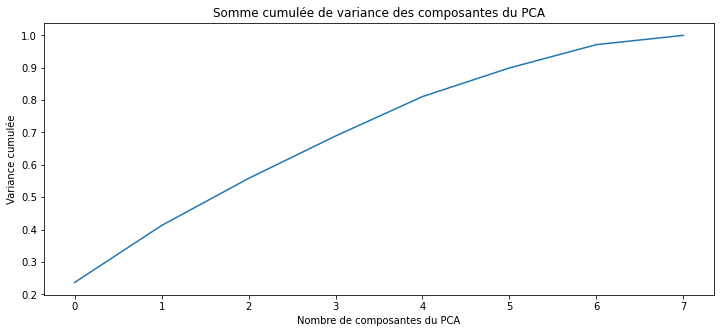

Features: 7
Cumulative Variance: 1.0



In [9]:
X, pca, X_pca, d = pcaF(data_cui_reduced, size='reduced')

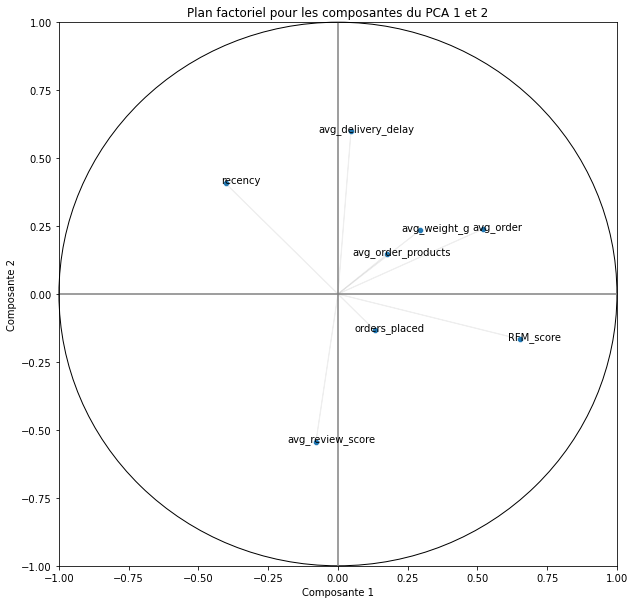

In [10]:
pcaGraph(X, pca, comp1=1, comp2=2)

# Clustering
L'objectif est de regrouper des instances similaires en clusters. Le clustering est un excellent outil pour l'analyse des données, la segmentation des clients, les systèmes de recommandation, les moteurs de recherche, la segmentation d'images, l'apprentissage semi-supervisé, la réduction de la dimensionnalité, etc.

Pour la segmentation des clients, il est possible de regrouper les clients en fonction de leurs achats et de leur activité sur le site. Ceci est utile pour comprendre qui sont les clients et ce dont ils ont besoin, afin que les produits et les campagnes marketing puissent être adaptés à chaque segment. Par exemple, la segmentation des clients peut être utile dans les systèmes de recommandation pour suggérer du contenu que d'autres utilisateurs du même cluster ont apprécié.

Pour un apprentissage semi-supervisé, il est possible s'il n'y a que quelques étiquettes, il est possible d'effectuer un clustering et de propager les étiquettes à toutes les instances d'un même cluster. Cette technique peut augmenter considérablement le nombre d'étiquettes disponibles pour un algorithme d'apprentissage supervisé ultérieur et ainsi améliorer ses performances.

Mais... Qu'est-ce qu'un cluster? Il n'y a pas de définition universelle de ce qu'est un cluster : cela dépend vraiment du contexte et différents algorithmes captureront différents types de clusters. Certains algorithmes recherchent des instances centrées autour d'un point particulier, appelé centroïde. D'autres recherchent des régions continues d'instances densément compactées : ces clusters peuvent prendre n'importe quelle forme. Certains algorithmes sont hiérarchiques et recherchent des clusters de clusters. Et la liste continue...

## K-Means
Cela fonctionne en commençant à placer le centre de gravité de manière aléatoire, puis en étiquetant les instances, en mettant à jour les centres de gravité, en étiquetant les instances, en mettant à jour les centres de gravité, etc. jusqu'à ce que les centres de gravité arrêtent de bouger. L'algorithme est garanti pour converger en un nombre fini d'étapes, il n'oscille pas indéfiniment.

La complexité de calcul de l'algorithme est généralement linéaire en ce qui concerne le nombre d'instances, le nombre de clusters et le nombre de dimensions. Cependant, cela n'est vrai que lorsque les données ont une structure de clustering. Si ce n'est pas le cas, la complexité peut augmenter de façon exponentielle avec le nombre d'instances. En pratique, cela se produit rarement, et K-Means est généralement l'un des algorithmes de clustering les plus rapides.

**Problématique :** Bien que l'algorithme soit assuré de converger, il peut ne pas converger vers la bonne solution. Que ce soit le cas ou non dépend de l'initialisation du centroïde.

### Centroid initialization methods
Si les emplacements des centres de gravité sont connus, il est possible de définir l'hyperparamètre *init* sur un tableau Numpy contenant la liste des centres de gravité et de définir *n_init* sur 1.

Une autre solution consiste à exécuter l'algorithme plusieurs fois avec différentes initialisations aléatoires et à conserver la meilleure solution. Le nombre d'initialisations aléatoires est contrôlé par l'hyperparamètre *n_init*: par défaut est 10 ce qui signifie que l'algorithme s'exécute 10 fois lorsque *fit()* est appelé et Scikit-Learn conserve la meilleure solution. Cette solution utilise l'inertie du modèle (*inertia*) comme mesure de performance, qui est la distance quadratique moyenne entre chaque instance et son centre de gravité le plus proche. La classe KMeans exécute l'algorithme *n_init* fois et conserve le modèle avec la plus faible inertie.

Une autre solution est *k-means++*. Cette solution est une étape d'initialisation qui a tendance à sélectionner des centres de gravité éloignés les uns des autres et cette amélioration rend l'algorithme K-Means beaucoup moins susceptible de converger vers une solution sous-optimale. Il permet de réduire drastiquement le nombre de fois où l'algorithme doit être exécuté pour trouver la solution optimale.

### Nombre de clusters ?
L'inertie n'est pas une bonne mesure de performance lorsque vous essayez de choisir *k*, car elle diminue à mesure que *k* augmente. En effet, plus il y a de clusters, plus chaque instance sera proche de son centre de gravité le plus proche et donc plus l'inertie sera faible. L'inertie diminue très rapidement à mesure que *k* augmente, mais elle diminue ensuite beaucoup plus lentement à mesure que *k* continue d'augmenter. Cette courbe a peu près la forme d'un bras et il y a un "coude" (elbow) où toute valeur inférieure serait dramatique alors qu'une valeur plus élevée n'aiderait pas beaucoup. Cette technique de choix de la meilleure valeur pour le nombre de clusters est plutôt grossière.

Une approche plus précise (mais aussi plus coûteuse en calcul) consiste à utiliser le **score de silhouette** qui est le coefficient de silhouette moyen sur toutes les instances. Le coefficient de silhouette d'une instance est égal à (B - A) / max (B) où A est la distance moyenne aux autres instances du même cluster (la distance moyenne intra-cluster) et B est la distance moyenne du cluster le plus proche (moyenne distance par rapport aux instances du cluster suivant le plus proche, défini comme celui qui minimise B, à l'exclusion du propre cluster de l'instance).

Le coefficient de silhouette peut varier entre -1 et +1. Un coefficient proche de +1 signifie que l'instance est bien à l'intérieur de son propre cluster et loin des autres clusters, tandis qu'un coefficient proche de 0 signifie qu'elle est proche d'une limite de clister et enfin un coefficient proche de -1 signifie que l'instance peut ont été attribués au mauvais cluster. Cette visualisation est beaucoup plus riche que la comparaison des inerties avec la méthode du coude.

Autre approche est **l'index de Davies-Bouldin**. L'index est défini comme la mesure de similarité moyenne de chaque cluster avec son cluster le plus similaire où la similarité est le rapport des distances intra-cluster aux distances inter-cluster. Ainsi, des clusters plus éloignées et moins dispersés se traduiront par un meilleur score. L'index varie entre 0 (meilleure classification indiquant un meilleur regroupement) et l'infini (pire classification). Une bonne façon de visualisation de l'index est de représenter par rapport au nombre de clusters sur lesquels il est calculé, le nombre *k* pour lequel cette valeur est la plus faible est une bonne mesure du nomnbre de clusters  dans lesquelles les données pourraient idéalement être classes.

In [11]:
def kMeans(X, d):
    
    print('K-Means')
    inertia = {}
    #Inertia: mean squared distance between each instance and its closest centroid.
    #KMeans class runs the algorithm n_init (10 by default) times and keeps the model with the lowest inertia.
    dict_kmeans = {}
    print('Fitting K-Means')
    
    start_k = time.time()
    for k in range(1,d+1):
        #k-means++ tends to select centroids that are distant from one another, this makes KMeans less likely  
        #to converge to a suboptimal solution. It's init's default value.
        kmeans = KMeans(n_clusters=k, 
                        init='k-means++', 
                        verbose=0,
                        random_state=0,
                        n_jobs=-1,
                       ).fit(X)
        print('.', end='')
        inertia[k] = kmeans.inertia_
        dict_kmeans[k] = kmeans
    print('done', end='\n')
    end_k = time.time()
    
    plt.figure(figsize=(12,5))
    plt.title('Somme des inerties en fonction du nombre de clusters')
    sns.lineplot(list(inertia.keys()), list(inertia.values()))
    plt.show()
    print()
    
    print('Calculating Silhouettes Score')
    silhouettes_kmeans = {}
    start_s = time.time()
    for i in range(2,d+1):
        silhouettes_kmeans[i] = silhouette_score(X=X, 
                                                 labels=list(dict_kmeans[i].labels_))
        print('.', end='')
    print('done', end='\n')
    end_s = time.time()
    
    plt.figure(figsize=(12,5))
    plt.title('Coefficient de silhouette moyen en fonction du nombre de clusters (kmeans)')
    sns.lineplot(list(silhouettes_kmeans.keys()), list(silhouettes_kmeans.values()))
    plt.show()
    print()
    
    print('Calculating Davies Bouldin Score')
    davies_bouldin_kmeans = {}
    start_db = time.time()
    for i in range(2, d+1):
        davies_bouldin_kmeans[i] = davies_bouldin_score(X=X,
                                                        labels=list(dict_kmeans[i].labels_))
        print('.', end='')
    print('done', end='\n')
    end_db = time.time()
    
    plt.figure(figsize=(12,5))
    plt.title('Davies Bouldin Score moyen en fonction du nombre de clusters (kmeans)')
    sns.lineplot(list(davies_bouldin_kmeans.keys()), list(davies_bouldin_kmeans.values()))
    plt.show()
    print()
    
    hours, rem = divmod(end_k-start_k, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Elapsed Time for K-Means: {:0>2}:{:0>2}:{:05.2f}"
                .format(int(hours),int(minutes),seconds), end='\n')
    
    hours, rem = divmod(end_s-start_s, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Elapsed Time for Silhouettes: {:0>2}:{:0>2}:{:05.2f}"
                .format(int(hours),int(minutes),seconds), end='\n')
    
    hours, rem = divmod(end_db-start_db, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Elapsed Time for Davies Bouldin: {:0>2}:{:0>2}:{:05.2f}"
                .format(int(hours),int(minutes),seconds), end='\n\n')
    
    for key, value in silhouettes_kmeans.items():
        if value == max(silhouettes_kmeans.values()):
            print('Silhouette Score est maximal pour {} clusters (score = {})'.format(key, value), end='\n')
            n_clusters_silhouettes_kmeans = key

    for key, value in davies_bouldin_kmeans.items():
        if value == min(davies_bouldin_kmeans.values()):
            print('Davies Bouldin Score est minimal pour {} clusters (score = {})'.format(key, value), end='\n\n')
            n_clusters_davies_bouldin_kmeans = key
            
    return n_clusters_silhouettes_kmeans, n_clusters_davies_bouldin_kmeans, dict_kmeans

K-Means
Fitting K-Means
.......done


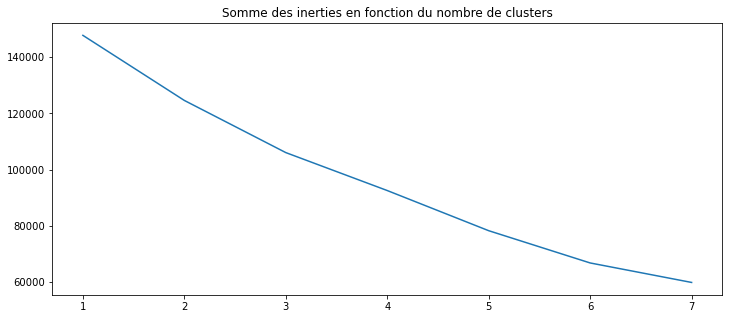


Calculating Silhouettes Score
......done


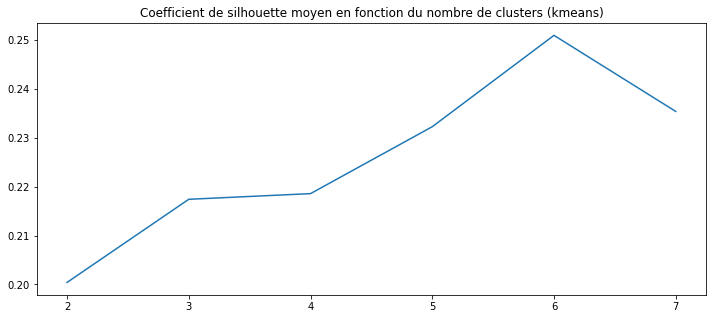


Calculating Davies Bouldin Score
......done


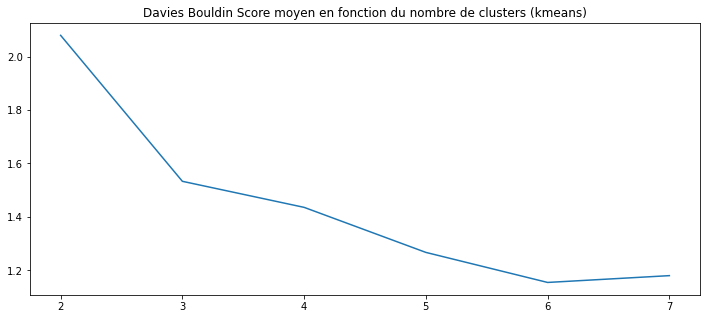


Elapsed Time for K-Means: 00:00:02.89
Elapsed Time for Silhouettes: 00:00:18.47
Elapsed Time for Davies Bouldin: 00:00:00.06

Silhouette Score est maximal pour 6 clusters (score = 0.2508723421618443)
Davies Bouldin Score est minimal pour 6 clusters (score = 1.1546707762804747)



In [12]:
n_clusters_silhouettes, n_clusters_davies_bouldin, dict_kmeans = kMeans(X, d)

## T-SNE
T-Distributed Stochastic Neighbor Embedding, réduit la dimensionnalité tout en essayant de garder les instances similaires proches et les instances différents séparées. Il est principalement utilisé pour la visualisation, en particulier pour visualiser des clusters dans un espace de haute dimensionnalité.

## DBScan
Cet algorithme définit les clusters comme des régions continues de haute densité. Pour chaque instance, l'algorithme compte le nombre d'instances situées à une petite distance *epsilon* de celle-ci. Cette région est appelée le quartier *epsilon-neighborhood* (voisinage epsilon). Si une instance a au moins des instances *min_samples* dans son voisinage epsilon (y compris lui-même), alors elle est considérée comme une *core instance* (instance principale). En d'autres termes, les instances principales sont celles qui sont situées dans des régions denses. Toutes les instances dans le voisinage d'une instance principale appartiennent au même cluster. Ce voisinage peut inclure d'autres instances pricipales, par conséquent une longue séquence d'instances principales voisines forme un seul cluster. Toute instance qui n'est pas une instance principale et qui n'en possède pas dans son voisinage est considérée comme une anomalie. Cet algorithme fonctionne bien si tous les clusters sont suffisamment denses et s'ils sont bien séparés par des régions à faible densité.

De manière assez surprenante, la classe DBSCAN n'a pas de méthode *predict()*, bien qu'elle ait une méthode *fit_predict()*. Il ne peut pas prédire à quel cluster appartient une nouvelle instance.

## AgglomerativeClustering

Une hiérarchie de clusters est construite de bas en haut, à chaque itération, le clustering agglomératif connecte la paire de clusters la plus proche (en commençant par les instances individuelles). Comme un arbre avec une branche pour chaque paire de clusters qui ont fusionné où les feuilles sont les instances individuelles. Cette approche s'adapte très bien à un grand nombre d'instances ou de clusters.

In [13]:
def tsne(X, d, dict_kmeans):
    
    #perplexity = round(X.shape[0]*0.05)
    
    print('T-SNE', end='\n')
    print('T-SNE fitting...', end='')
    
    start_t = time.time()
    tsne = TSNE(n_components=2,
                perplexity=50, #30
                init='pca',
                random_state=0,
                n_iter=1000,
                n_jobs=-1,
               )
    T = tsne.fit_transform(X.copy())
    end_t = time.time()
    print('done', end='\n')
    
    hours, rem = divmod(end_t-start_t, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Elapsed Time for T-SNE: {:0>2}:{:0>2}:{:05.2f}"
                .format(int(hours),int(minutes),seconds), end='\n')

    graph_df = pd.DataFrame(data=[T[:,0], T[:,1], dict_kmeans[d].labels_]).T
    graph_df.columns = ['X', 'Y', 'label_kmeans']
    graph_df.head()
    
    return T, graph_df

In [14]:
def dbscan(X):
    
    print('DBScan', end='\n')
    print('DBScan fitting...', end='')
    start_dbs = time.time()
    dbs = DBSCAN(eps=0.5, 
                 min_samples=5,
                 n_jobs=-1,
                 metric='euclidean' #default value
                ).fit(X)
    end_dbs = time.time()
    print('done', end='\n')
    
    hours, rem = divmod(end_dbs-start_dbs, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Elapsed Time for DBSCAN: {:0>2}:{:0>2}:{:05.2f}"
                .format(int(hours),int(minutes),seconds), end='\n')
    
    print('Number of clusters: {}'.format(len(set(dbs.labels_[np.where(dbs.labels_ != -1)]))), end='\n')
    print("Silhouette Score:", metrics.silhouette_score(X, dbs.labels_), end='\n')
    print("Davies Bouldin Score:", metrics.davies_bouldin_score(X, dbs.labels_), end='\n\n')
    
    return dbs

In [15]:
def clustering(X, n_clusters):
    
    print('AgglomerativeClustering', end='\n')
    print('AgglomerativeClustering fitting...', end='')
    clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(X)
    print('done', end='\n')
    
    print('Number of clusters: {}'.format(len(set(clustering.labels_[np.where(clustering.labels_ != -1)]))), end='\n')
    print("Silhouette Score:", metrics.silhouette_score(X, clustering.labels_), end='\n')
    print("Davies Bouldin Score:", metrics.davies_bouldin_score(X, clustering.labels_), end='\n\n')

    return clustering

In [16]:
T, graph_df = tsne(X_pca, n_clusters_davies_bouldin, dict_kmeans)

T-SNE
T-SNE fitting...done
Elapsed Time for T-SNE: 00:01:56.83


In [17]:
dbs = dbscan(X)

DBScan
DBScan fitting...done
Elapsed Time for DBSCAN: 00:00:01.28
Number of clusters: 147
Silhouette Score: -0.28918714444548366
Davies Bouldin Score: 1.7716247492719184



In [18]:
start_s = time.time()
clustering_s = clustering(X, n_clusters_silhouettes)
end_s = time.time()

AgglomerativeClustering
AgglomerativeClustering fitting...done
Number of clusters: 6
Silhouette Score: 0.19536002204625852
Davies Bouldin Score: 1.303567287258169



In [19]:
start_db = time.time()
clustering_db = clustering(X, n_clusters_davies_bouldin)
end_db = time.time()

AgglomerativeClustering
AgglomerativeClustering fitting...done
Number of clusters: 6
Silhouette Score: 0.19536002204625852
Davies Bouldin Score: 1.303567287258169



In [20]:
elapsed_time(start_s, end_s, n_clusters_silhouettes)
elapsed_time(start_db, end_db, n_clusters_davies_bouldin)

Elapsed Time for 6 clusters: 00:00:17.27
Elapsed Time for 6 clusters: 00:00:17.16


## Graphiques

In [21]:
def makeGraphs(n_clusters, dict_kmeans, T, graph_df, clustering, dbs):
    
    fig, axes = plt.subplots(2, 2, figsize=(25, 20))

    sns.scatterplot(ax=axes[0, 0], 
                    x=T[:,0], y=T[:,1])
    g=axes[0, 0].set_title('T-SNE')

    sns.scatterplot(ax=axes[0, 1], 
                    x=T[:,0], y=T[:,1], 
                    hue=dict_kmeans[n_clusters].labels_, 
                    legend='full', 
                    palette=sns.color_palette("hls", n_clusters))
    g=axes[0, 1].set_title('T-SNE de K-Means ({} clusters)'.format(n_clusters))
    
    sns.scatterplot(ax=axes[1, 0], 
                    x=graph_df['X'], y=graph_df['Y'], 
                    hue = clustering.labels_, 
                    legend='full',
                    palette=sns.color_palette("hls", n_clusters))
    l=axes[1, 0].legend(loc='upper left', labels=graph_df['label_kmeans'].unique())
    g=axes[1, 0].set_title('Séparation des données du AgglomerativeClustering avec T-SNE ({} clusters)'.format(n_clusters))

    sns.scatterplot(ax=axes[1, 1], 
                    x=T[:,0], y=T[:,1], 
                    hue=dbs.labels_)
    g=axes[1, 1].set_title('Séparation des données du DBSCAN avec T-SNE')
    
    plt.show()
    
    return

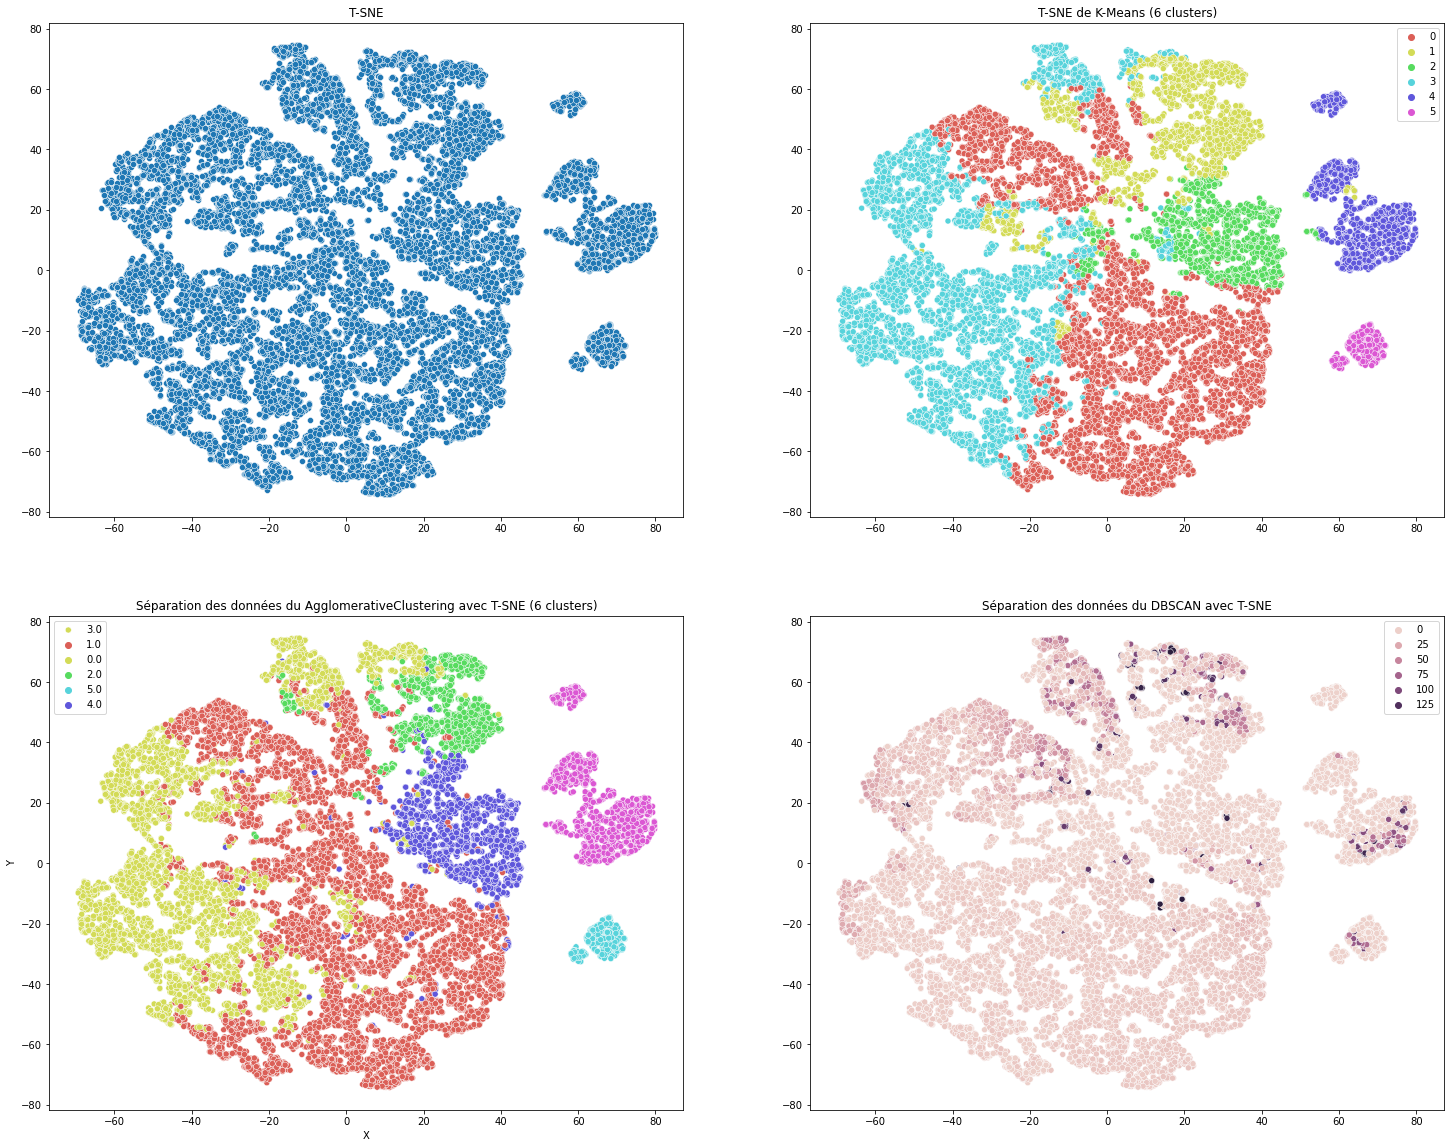

In [22]:
makeGraphs(n_clusters_silhouettes, dict_kmeans, T, graph_df, clustering_s, dbs)

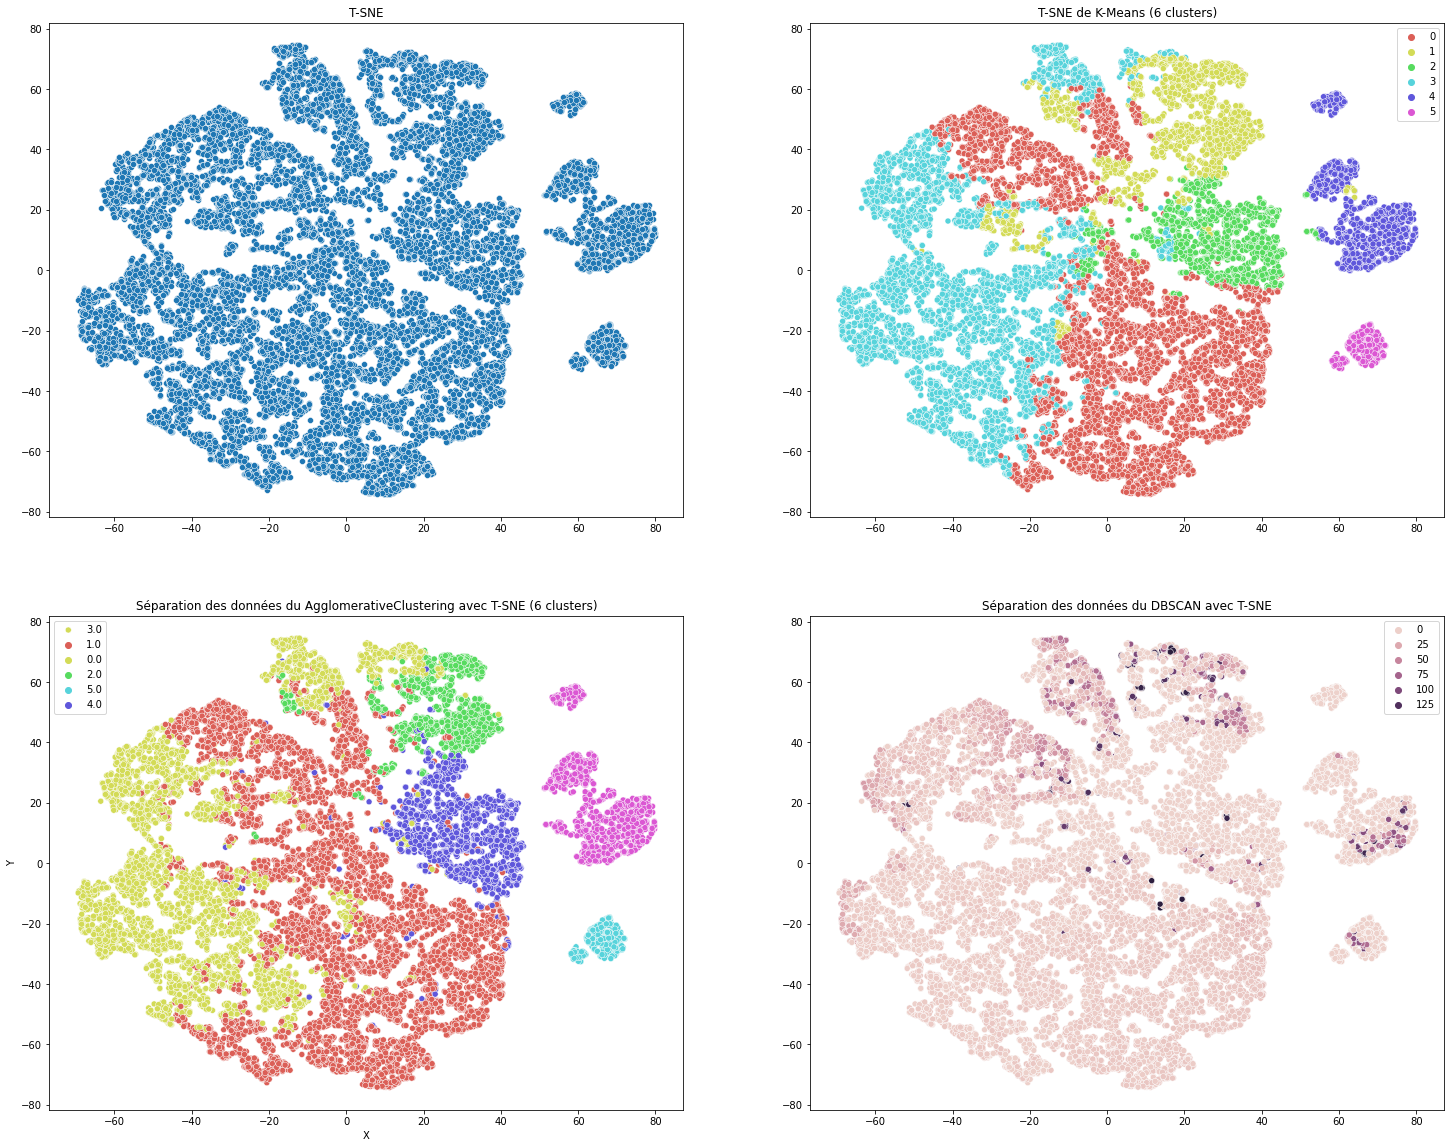

In [23]:
makeGraphs(n_clusters_davies_bouldin, dict_kmeans, T, graph_df, clustering_db, dbs)

Supprimer des variables pour vider la mémoire

In [24]:
del X, T, pca, X_pca, graph_df, dict_kmeans, dbs, clustering_s, clustering_db, n_clusters_silhouettes, n_clusters_davies_bouldin, d

# Jeux des données complet. Même situation ?

X shape: (73865, 8)

PCA


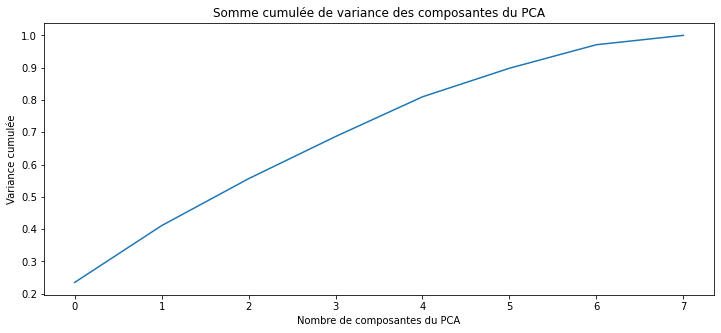

Features: 7
Cumulative Variance: 1.0



In [25]:
X_full, pca_full, X_pca_full, d_full = pcaF(data_cui_reduced, size='full')

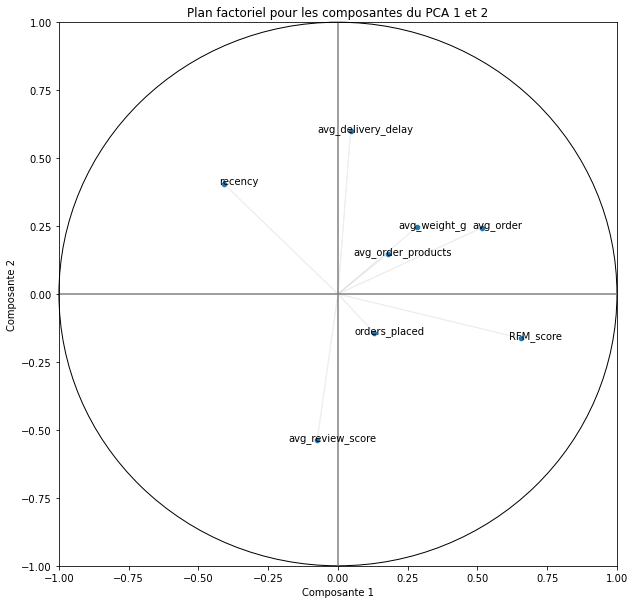

In [26]:
pcaGraph(X_full, pca_full, comp1=1, comp2=2)

K-Means
Fitting K-Means
.......done


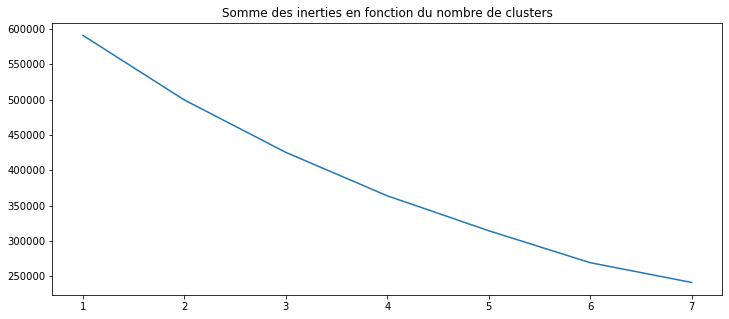


Calculating Silhouettes Score
......done


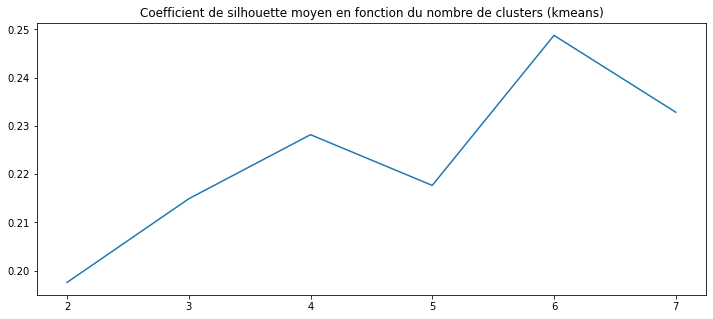


Calculating Davies Bouldin Score
......done


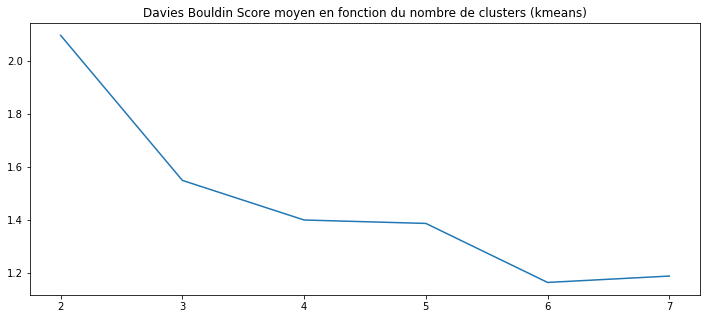


Elapsed Time for K-Means: 00:00:08.38
Elapsed Time for Silhouettes: 00:04:42.42
Elapsed Time for Davies Bouldin: 00:00:00.17

Silhouette Score est maximal pour 6 clusters (score = 0.24876720627524687)
Davies Bouldin Score est minimal pour 6 clusters (score = 1.1641811456165556)



In [27]:
n_c_s_full, n_c_db_full, dict_kmeans_full = kMeans(X_full, d_full)

In [28]:
T_full, graph_df_full = tsne(X_pca_full, n_c_db_full, dict_kmeans_full)

T-SNE
T-SNE fitting...done
Elapsed Time for T-SNE: 00:06:45.59


In [29]:
dbs_full = dbscan(X_full)

DBScan
DBScan fitting...done
Elapsed Time for DBSCAN: 00:00:10.17
Number of clusters: 309
Silhouette Score: -0.2372596616801779
Davies Bouldin Score: 1.8794868772508277



In [30]:
start_s = time.time()
clustering_s = clustering(X_full, n_c_s_full)
end_s = time.time()

AgglomerativeClustering
AgglomerativeClustering fitting...done
Number of clusters: 6
Silhouette Score: 0.16265416356723955
Davies Bouldin Score: 1.3929224992214688



In [31]:
start_db = time.time()
clustering_db = clustering(X_full, n_c_db_full)
end_db = time.time()

AgglomerativeClustering
AgglomerativeClustering fitting...done
Number of clusters: 6
Silhouette Score: 0.16265416356723955
Davies Bouldin Score: 1.3929224992214688



In [32]:
elapsed_time(start_s, end_s, n_c_s_full)
elapsed_time(start_db, end_db, n_c_db_full)

Elapsed Time for 6 clusters: 00:16:54.40
Elapsed Time for 6 clusters: 00:13:04.01


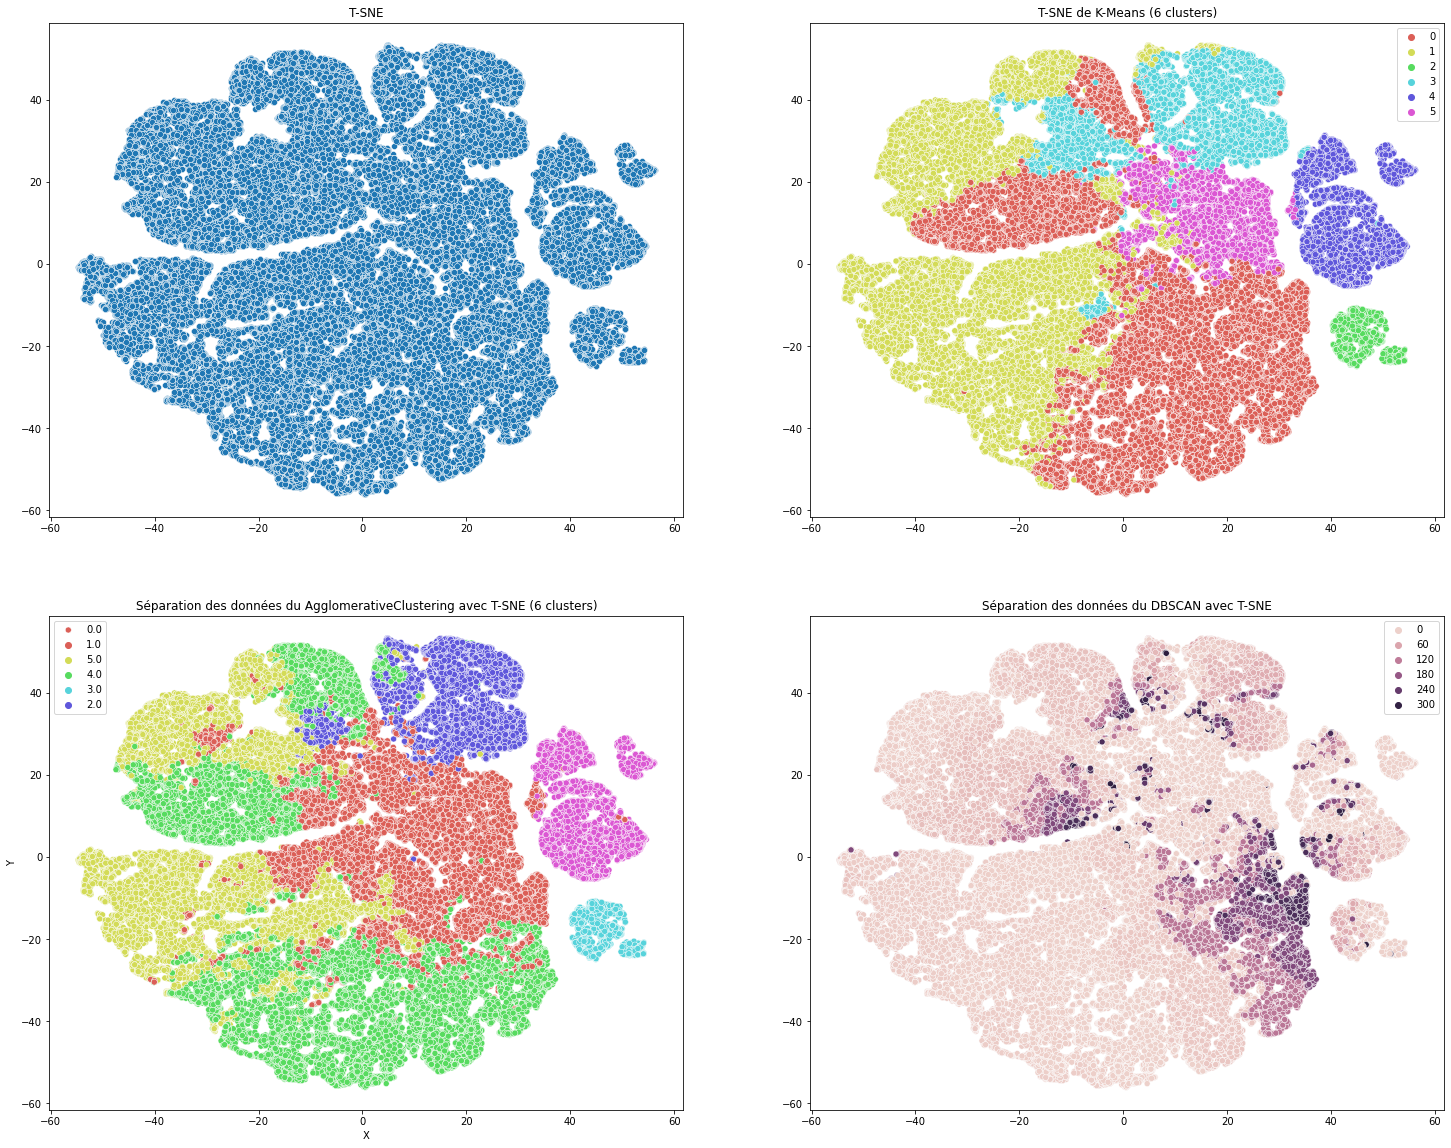

In [33]:
makeGraphs(n_c_s_full, dict_kmeans_full, T_full, graph_df_full, clustering_s, dbs_full)

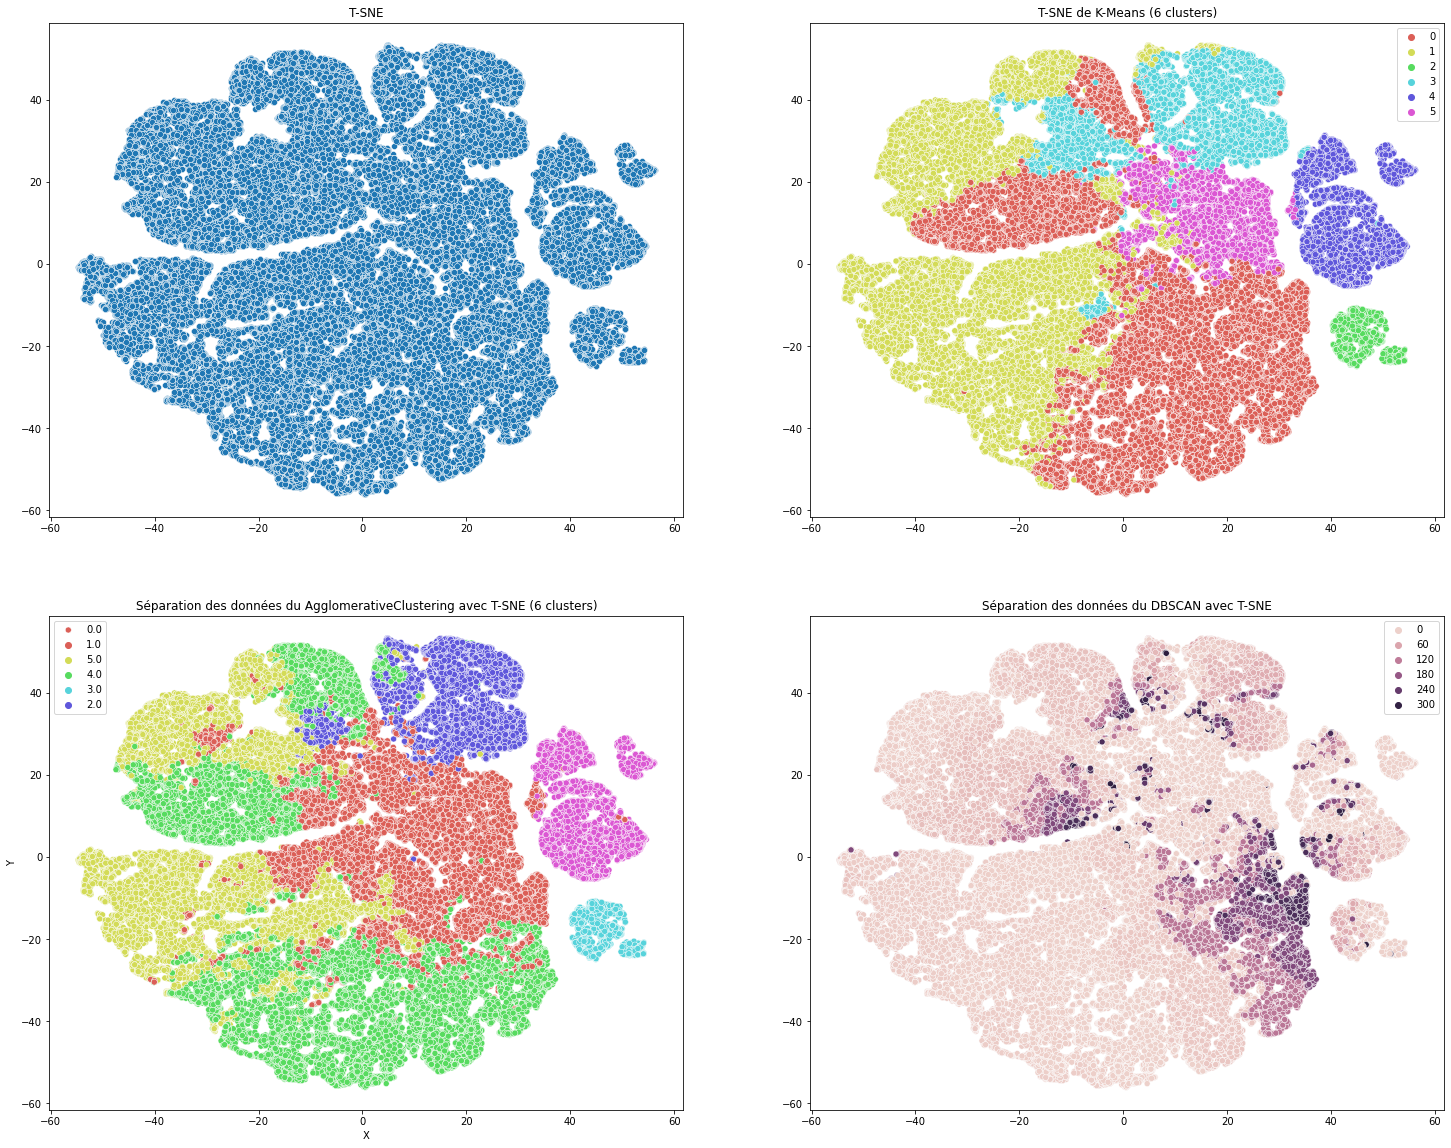

In [34]:
makeGraphs(n_c_db_full, dict_kmeans_full, T_full, graph_df_full, clustering_db, dbs_full)

**6 clusters** semble être le résultat le plus stable.

In [35]:
X_full['label_kmeans'] = dict_kmeans_full[n_c_db_full].labels_
X_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73865 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   orders_placed       73865 non-null  float64
 1   avg_review_score    73865 non-null  float64
 2   avg_order_products  73865 non-null  float64
 3   avg_order           73865 non-null  float64
 4   avg_weight_g        73865 non-null  float64
 5   avg_delivery_delay  73865 non-null  float64
 6   recency             73865 non-null  float64
 7   RFM_score           73865 non-null  float64
 8   label_kmeans        73865 non-null  int32  
dtypes: float64(8), int32(1)
memory usage: 7.4+ MB


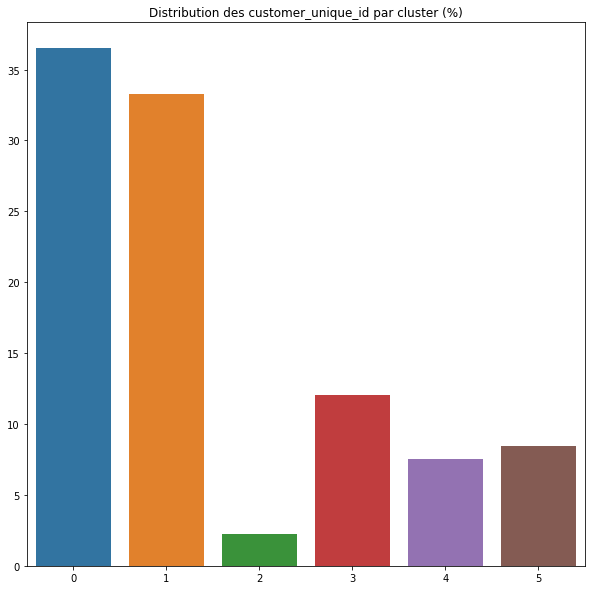

In [36]:
plt.figure(figsize=(10,10))
plt.title('Distribution des customer_unique_id par cluster (%)')
sns.barplot(x=X_full['label_kmeans'].value_counts().index, 
            y=X_full['label_kmeans'].value_counts().values/len(graph_df_full)*100)
plt.show()

In [37]:
df_labels = data_cui_reduced.copy()
df_labels['label_kmeans'] = dict_kmeans_full[n_c_db_full].labels_

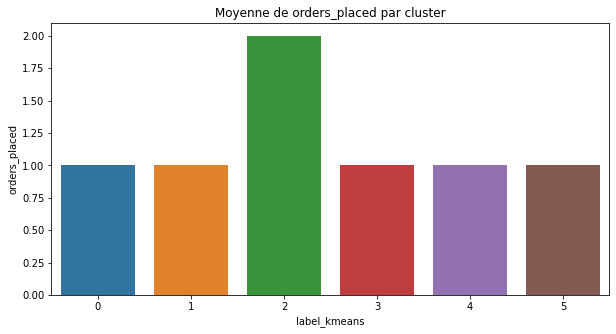

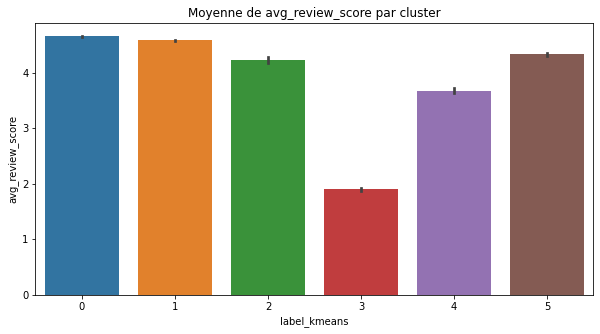

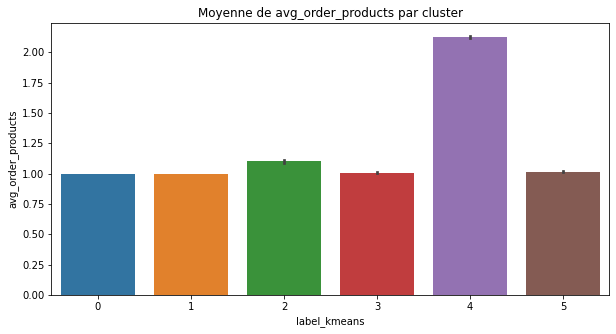

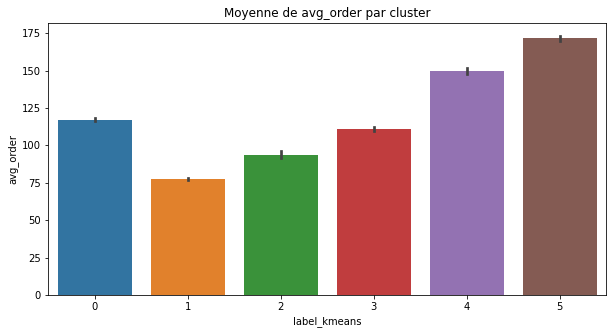

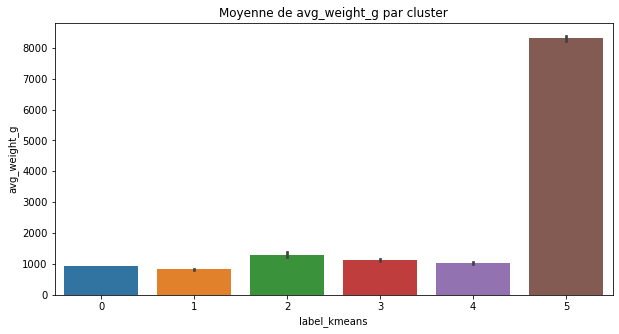

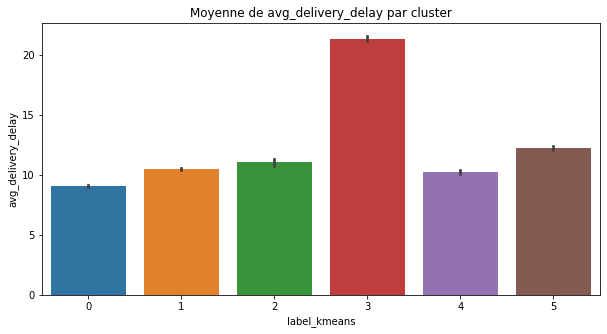

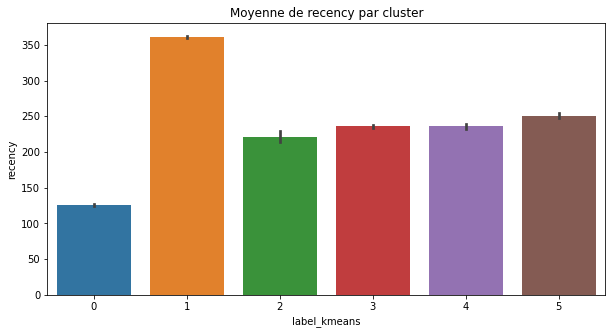

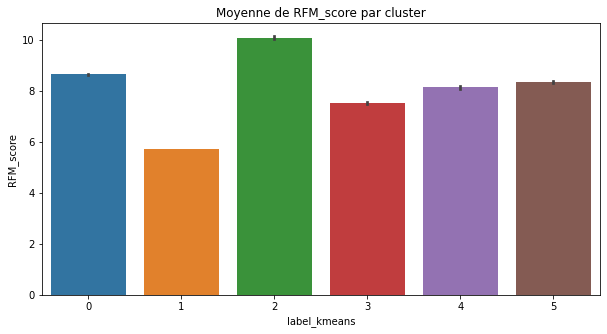

In [38]:
for col in df_labels.columns:
    if col != 'label_kmeans':
        if col != 'first_order_date':
            try:
                plt.figure(figsize=(10,5))
                title = 'Moyenne de ' + str(col) + ' par cluster' 
                plt.title(title)
                sns.barplot(x='label_kmeans',
                            y=col,
                            data=df_labels,
                           )
                plt.show()
            except:
                print('Erreur : ', col)

In [39]:
cId_cluster_q = df_labels.groupby(['label_kmeans'])['label_kmeans'].count()
cId_cluster_q.sort_values(ascending=False)

label_kmeans
0    26969
1    24570
3    8879 
5    6233 
4    5538 
2    1676 
Name: label_kmeans, dtype: int64

In [40]:
df_labels.groupby('label_kmeans').agg('mean')

orders_placed  avg_review_score  avg_order_products   avg_order  \
label_kmeans                                                                    
0             1.0            4.651266          1.000000            117.236737   
1             1.0            4.581604          1.000081            77.511574    
2             2.0            4.227924          1.100835            93.712912    
3             1.0            1.900552          1.007546            110.709122   
4             1.0            3.676598          2.124594            149.965125   
5             1.0            4.328895          1.016044            171.511112   

              avg_weight_g  avg_delivery_delay     recency  RFM_score  
label_kmeans                                                           
0             938.106901    9.075197            126.221328  8.640587   
1             833.744607    10.470818           360.946642  5.715181   
2             1305.497912   11.040573           221.688544  10.079952  
3             1134.451965   21.324811           235.883433  7.521568   
4             1029.245576   10.238173           236.020043  8.130372   
5             8300.967111   12.213541           250.683299  8.356329

In [41]:
# df_labels[['label_kmeans', 
#            'customer_state', 
#            'prefered_product_category', 
#            'prefered_payment_type',
#            ]].groupby('label_kmeans').agg(lambda x:x.value_counts().index[0])

In [42]:
df_labels.groupby('label_kmeans').agg('mean').max()

orders_placed         2.000000   
avg_review_score      4.651266   
avg_order_products    2.124594   
avg_order             171.511112 
avg_weight_g          8300.967111
avg_delivery_delay    21.324811  
recency               360.946642 
RFM_score             10.079952  
dtype: float64

In [43]:
df_labels.groupby('label_kmeans').agg('mean').min()

orders_placed         1.000000  
avg_review_score      1.900552  
avg_order_products    1.000000  
avg_order             77.511574 
avg_weight_g          833.744607
avg_delivery_delay    9.075197  
recency               126.221328
RFM_score             5.715181  
dtype: float64

| `Clusters` | `Description` |
| ---------- | ------------- |
| **Cluster 0** | - Meilleure recency<br> - Délai de livraison le plus bas (en moyenne)<br> - Les meilleures note<br> - Deuxième RFM Score |
| **Cluster 1** | - Pire recency<br> - Moins dépensé et le moins de poids acheté<br> - Très bonnes notes<br> - Pire RFM Score |
| **Cluster 2** | - Le plus des commandes passées<br> - Très bonnes notes<br> - Première RFM Score |
| **Cluster 3** | - Les pires notes<br> - Délai de livraison le plus élevé |
| **Cluster 4** | - Plus d'un produit acheté par commande<br> - Notes moyennes |
| **Cluster 5** | - Le plus dépensé et le plus de poids achete<br> - Très bonnes notes<br> - Deuxième pire recency | 

Nous devons sauvegarder le modèle puisque chaque itération change le numéro de chaque cluster (mais pas leurs caractéristiques) pour créer une base permanente à partir de laquelle identifier les clusters au fil du temps à chaque nouvelle itération.

In [44]:
# clusters_dict = {
#     0 : 'A',
#     1 : 'B',
#     2 : 'C',
#     3 : 'D',
#     4 : 'E',
#     5 : 'F',
# }

# df_labels['clusters'] = df_labels['label_kmeans'].astype('object')
# df_labels['clusters'] = df_labels['clusters'].replace(clusters_dict, regex=False)

In [45]:
# #export modèle
# filename = 'df_labels.obj' 
# with open(filename, 'wb') as f1:
#     pickle.dump(df_labels, f1)

#import modèle
filename = 'df_labels.obj' 
with open(filename, 'rb') as f1:
    model = pickle.load(f1)

In [46]:
#Dictionary based on the Pickle file
cluster_labels = {
    'A' : 0,
    'B' : 1,
    'C' : 2,
    'D' : 3,
    'E' : 4,
    'F' : 5,
}
inv_cluster_labels = dict(map(reversed, cluster_labels.items()))

#import the Pickle file's clusters
df_labels['clusters'] = model['clusters']

#Create a new dictionary with the mean of the label_kmeans for each 'clusters' column value from the Pickle
temp = round(df_labels.groupby(['clusters'])['label_kmeans'].mean()).to_dict()
inv_temp = dict(map(reversed, temp.items()))

#Replace the NaN of the new clients in the 'clusters' column with the aproximative value from the dictionary temp.
df_labels['clusters'] = df_labels['label_kmeans'].replace(inv_temp, regex=False)

#Cluster correction on the column 'label_kmeans' based on the dictionary from the Pickle file
df_labels['label_kmeans'] = df_labels['clusters'].replace(cluster_labels, regex=False)

#Drop 'clusters' column
df_labels = df_labels.drop(['clusters'], axis=1)

## Clusters par Category

In [48]:
data_cui['label_kmeans'] = df_labels['label_kmeans']
data_cui.groupby('label_kmeans')['appliances', 'beauty', 'culture', 'fashion', 'food', 'garden', 
                                 'home', 'no_name', 'other', 'services', 'sports', 'tech', 'tools'].agg('sum')

appliances     beauty    culture    fashion   food     garden  \
label_kmeans                                                                  
0             205211.34   577424.48  145275.12  581443.80  97.23  107246.56   
1             135333.23   276583.77  141764.69  229197.20  18.87  97852.00    
2             27163.26    43245.11   13080.67   45095.45   18.87  12182.12    
3             51806.77    147088.53  47207.72   163287.15  18.87  31018.21    
4             65172.57    95264.08   24038.13   77180.35   11.36  53687.42    
5             147639.54   26796.32   34232.37   142073.22  20.66  68955.52    

                   home   no_name      other  services     sports       tech  \
label_kmeans                                                                   
0             458268.32  2135.60   294165.95  0.0       249797.18  463961.65   
1             335460.56  11721.73  176089.00  0.0       174335.92  308158.49   
2             86974.31   1057.13   17481.25   0.0       24928.06   41715.13    
3             178618.60  1377.54   89795.81   0.0       74624.89   181110.41   
4             277795.11  1461.51   30739.36   0.0       55211.50   136999.08   
5             304358.55  122.08    109749.14  0.0       42938.19   83852.96    

                 tools  
label_kmeans            
0             38146.16  
1             9365.16   
2             1752.14   
3             7038.94   
4             9255.54   
5             1806.03

In [49]:
data_cui[['label_kmeans', 
            'customer_state', 
            'prefered_product_category', 
            'prefered_payment_type',
           ]].groupby('label_kmeans').agg(lambda x:x.value_counts().index[0])

customer_state prefered_product_category prefered_payment_type
label_kmeans                                                               
0             SP             beauty                    credit_card         
1             SP             tech                      credit_card         
2             SP             home                      credit_card         
3             SP             tech                      credit_card         
4             SP             home                      credit_card         
5             SP             home                      credit_card

In [50]:
data_cui.groupby('label_kmeans')['appliances', 'beauty', 'culture', 'fashion', 'food', 'garden', 
                                 'home', 'no_name', 'other', 'services', 'sports', 'tech', 'tools'].agg('sum').max()

appliances    205211.34
beauty        577424.48
culture       145275.12
fashion       581443.80
food          97.23    
garden        107246.56
home          458268.32
no_name       11721.73 
other         294165.95
services      0.00     
sports        249797.18
tech          463961.65
tools         38146.16 
dtype: float64

In [51]:
data_cui.groupby('label_kmeans')['appliances', 'beauty', 'culture', 'fashion', 'food', 'garden', 
                                 'home', 'no_name', 'other', 'services', 'sports', 'tech', 'tools'].agg('sum').min()

appliances    27163.26
beauty        26796.32
culture       13080.67
fashion       45095.45
food          11.36   
garden        12182.12
home          86974.31
no_name       122.08  
other         17481.25
services      0.00    
sports        24928.06
tech          41715.13
tools         1752.14 
dtype: float64

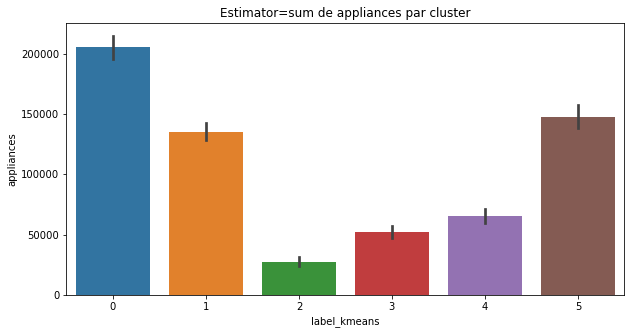

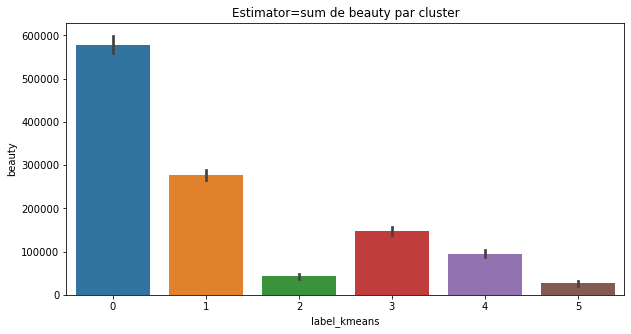

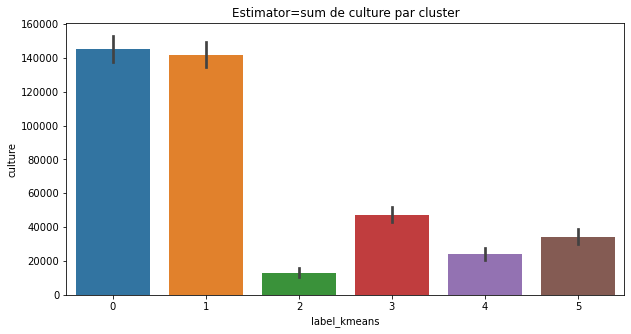

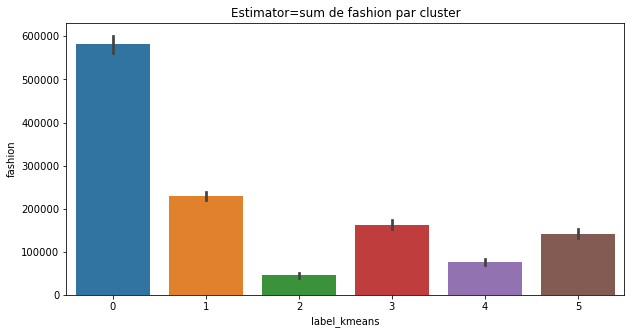

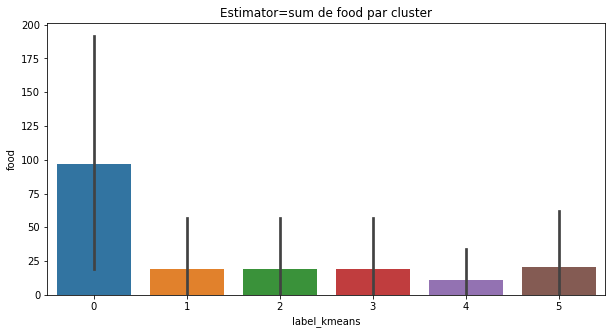

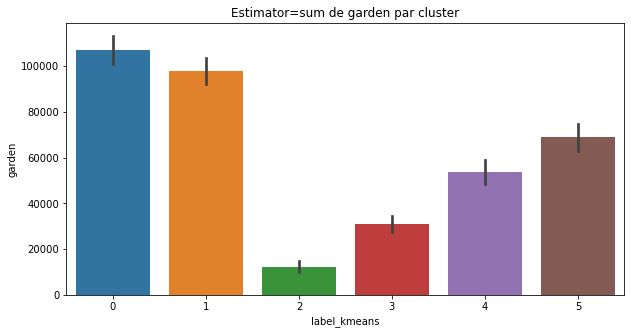

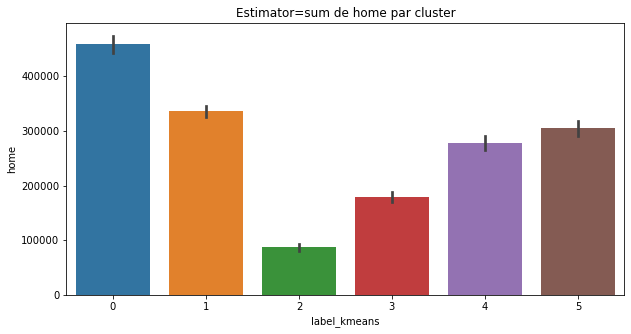

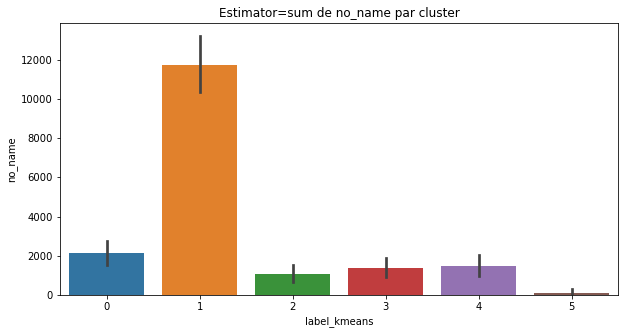

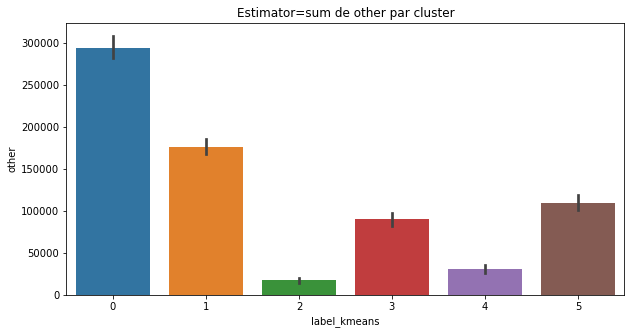

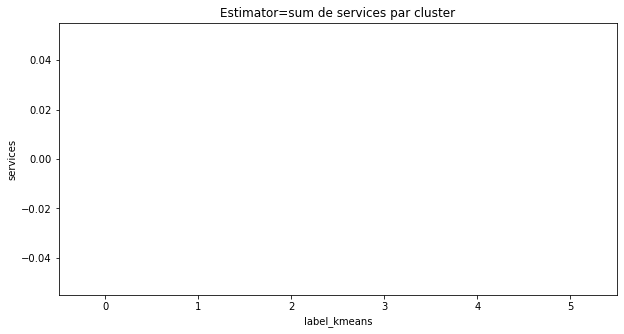

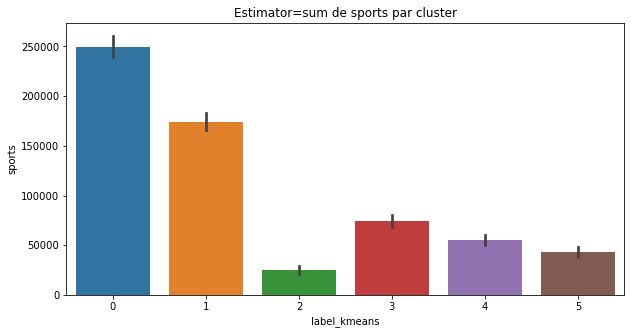

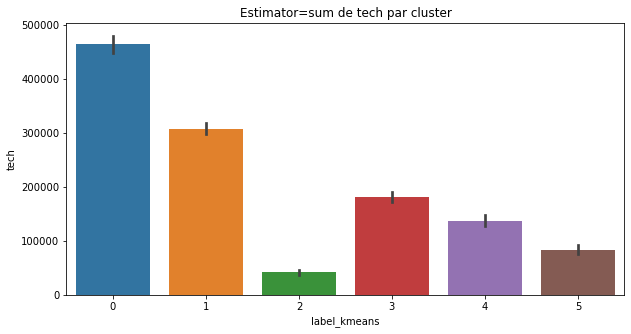

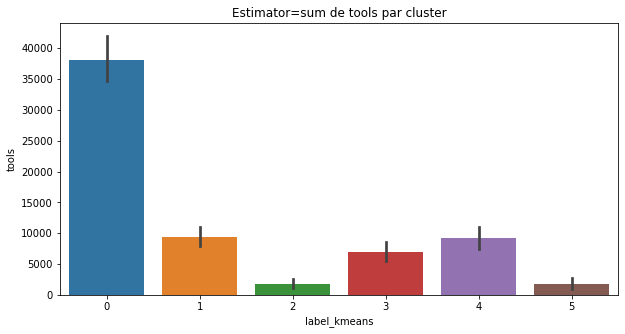

In [52]:
for col in ['appliances', 'beauty', 'culture', 'fashion', 'food', 'garden', 'home', 'no_name', 'other', 'services',
            'sports', 'tech', 'tools']:
    try:
        plt.figure(figsize=(10,5))
        title = 'Estimator=sum de ' + str(col) + ' par cluster' 
        plt.title(title)
        sns.barplot(x='label_kmeans',
                    y=col,
                    data=data_cui,
                    estimator=sum,
                   )
        plt.show()
    except:
        print('Erreur : ', col)

# Evolution mois-mois

In [53]:
data_cui['Y_M'] = data_cui['first_order_date'].dt.to_period('M')
df_periods = data_cui.groupby(['Y_M', 'label_kmeans'])['Y_M'].count().to_frame('count').pivot_table('count', ['Y_M'], 'label_kmeans').fillna(0).cumsum().reset_index()
df_periods['Y_M'] = df_periods['Y_M'].astype('str')

In [54]:
df_periods

label_kmeans      Y_M        0        1       2       3       4       5
0             2016-10  0.0      133.0    8.0     34.0    14.0    12.0  
1             2016-12  0.0      133.0    9.0     34.0    14.0    12.0  
2             2017-01  1.0      509.0    39.0    68.0    51.0    46.0  
3             2017-02  1.0      1441.0   74.0    171.0   129.0   152.0 
4             2017-03  12.0     2866.0   142.0   325.0   266.0   294.0 
5             2017-04  28.0     4105.0   199.0   519.0   395.0   416.0 
6             2017-05  66.0     6104.0   302.0   707.0   588.0   644.0 
7             2017-06  113.0    7808.0   402.0   909.0   748.0   904.0 
8             2017-07  189.0    9896.0   508.0   1131.0  966.0   1224.0
9             2017-08  322.0    12121.0  622.0   1399.0  1229.0  1531.0
10            2017-09  678.0    14022.0  731.0   1716.0  1456.0  1819.0
11            2017-10  1221.0   15844.0  832.0   2074.0  1723.0  2137.0
12            2017-11  2238.0   18377.0  971.0   3032.0  2183.0  2615.0
13            2017-12  3273.0   20118.0  1054.0  3751.0  2452.0  2985.0
14            2018-01  4937.0   21981.0  1185.0  4520.0  2856.0  3554.0
15            2018-02  6907.0   22981.0  1320.0  5570.0  3227.0  3963.0
16            2018-03  9198.0   23789.0  1420.0  6765.0  3623.0  4389.0
17            2018-04  12164.0  24416.0  1492.0  7342.0  4027.0  4893.0
18            2018-05  15723.0  24567.0  1549.0  7919.0  4477.0  5308.0
19            2018-06  19307.0  24570.0  1596.0  8227.0  4855.0  5667.0
20            2018-07  22978.0  24570.0  1656.0  8555.0  5181.0  5969.0
21            2018-08  26969.0  24570.0  1676.0  8879.0  5538.0  6233.0

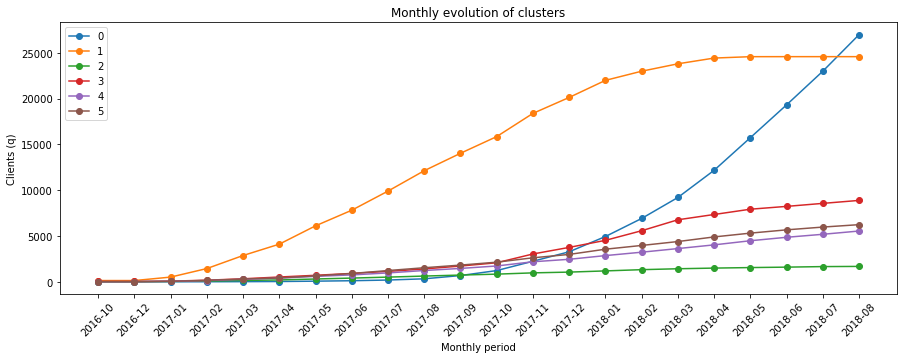

In [55]:
fig = plt.figure(figsize=(15,5))
ax = plt.gca()

for col in df_periods.columns:
    if col != 'Y_M':
        ax.plot(df_periods['Y_M'], df_periods[col], marker='o', label=col)

plt.xlabel('Monthly period')
plt.xticks(rotation=45)
plt.ylabel('Clients (q)')
plt.title('Monthly evolution of clusters')
plt.legend()
plt.show()

Les évolutions du Cluster 1 et 0 peuvent s'expliquer par la façon que la *recency* (récence) est calculée : la récence est la différence entre la date du dernier achat effectué par le client et la dernière date +1 jour dans l'ensemble du dataframe. De plus, le principal coupable de cette situation est que la majorité des clients n'ont qu'une seule commande, donc la récence stagne plus rapidement que d'habitude dans tout le dataframe.

Si nous supprimons la récence en tant que feature, nous nous retrouverons dans une situation où les clusters ne sont définis que par le comportement d'achat des clients, ce qui est assez similaire et pas très utile lors d'une segmentation client.

# Résultats

| `Clusters` | `Description` | `Nom` | `Action/Proposition` | `★` |
| ---------- | ------------- | :---: | -------------------- | :-: |
| **Cluster 0** | - Meilleure recency<br> - Délai de livraison le plus bas (en moyenne)<br> - Les meilleures note<br> - Deuxième RFM Score | **Loyal** | Action seulement si leur avis change | ★★★★☆ |
| **Cluster 1** | - Pire recency<br> - Moins dépensé et le moins de poids acheté<br> - Très bonnes notes<br> - Pire RFM Score | **Nécessite une activation** | Nous devons les reconquérir | ★☆☆☆☆ |
| **Cluster 2** | - Le plus des commandes passées<br> - Très bonnes notes<br> - Première RFM Score | **Ambassadeur** | Action seulement si leur avis change | ★★★★★ |
| **Cluster 3** | - Les pires notes<br> - Délai de livraison le plus élevé | **Malheureux** | Problème de livraison. Enquêter sur les délais de livraison et un éventuel changement de transporteur. | ☆☆☆☆☆ |
| **Cluster 4** | - Plus d'un produit acheté par commande<br> - Notes moyennes | **Nécessite de l'attention** | Les clients ont fait un premier achat mais on ne les a pas revus depuis.<br> Mécontents ?<br> Il faut créer la notoriété de la marque ? |★★☆☆☆ |
| **Cluster 5** | - Le plus dépensé et le plus de poids achete<br> - Très bonnes notes<br> - Deuxième pire recency | **Prometteur** | Ils montrent des signes prometteurs avec la valeur de leur achat, mais cela fait un moment qu'ils n'ont pas passé une commande.<br> Cibler les articles de leur liste de souhaits avec une réduction temporelle ?| ★★★☆☆ |